In [ ]:
!pip install xgboost scikit-learn pandas matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 14.4 MB/s eta 0:00:00a 0:00:01


## Import packages and Data

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

/var/folders/c2/l58_pxzx2tqb1lr7wlj_xt7h0000gn/T/ipykernel_5523/1518663791.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# Load the data
df = pd.read_csv('data/data_imputed.csv', index_col=['id', 'time'])
df

,,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,call,circumplex.arousal,circumplex.valence,mood,screen,sms
id,time,,,,,,,,,,,,,,,,,,,
AS14.08,2014-03-13,0.000000,14.101000,47.864667,0.000000,0.0,0.0,0.000000,26.106875,33.491833,0.000000,0.000000,13.062000,0.000000,0.0,0.000000,0.60,6.60,55.066533,1.0
AS14.13,2014-03-13,0.000000,7.169667,46.672273,36.754000,0.0,0.0,0.000000,46.723600,174.092000,0.000000,0.000000,13.062000,0.000000,1.0,-2.000000,1.00,7.00,83.482467,1.0
AS14.16,2014-03-13,0.000000,4.913900,30.734167,36.754000,0.0,0.0,0.000000,36.415238,103.791917,0.000000,0.000000,13.062000,0.000000,1.0,-0.500000,1.50,8.00,22.923222,1.0
AS14.17,2014-03-13,0.000000,8.728189,41.757035,36.754000,0.0,0.0,0.000000,36.415238,103.791917,0.000000,0.000000,13.062000,0.000000,1.0,0.750000,0.75,7.25,53.824074,1.0
AS14.05,2014-03-14,0.000000,15.121824,49.573057,4.144754,0.0,0.0,0.000000,44.801875,58.581125,0.000000,0.000000,9.552333,0.000000,1.0,-1.000000,2.00,8.00,63.892159,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AS14.26,2014-05-29,0.028571,3.106714,18.806000,58.141857,0.0,0.0,44.738625,3.524500,62.085461,64.460083,0.000000,5.111000,15.360083,1.0,0.000000,0.80,7.40,64.947000,1.0
AS14.33,2014-05-29,0.169354,6.452161,54.388125,68.369000,0.0,0.0,44.738625,9.734000,198.880222,0.939000,0.000000,1.599500,15.360083,1.0,-1.333333,1.00,7.00,118.978033,1.0
AS14.24,2014-05-30,0.035684,8.586340,56.645530,56.138286,0.0,0.0,44.738625,9.038200,19.399769,0.939000,0.000000,2.519500,0.000000,1.0,0.200000,1.20,7.40,98.698707,1.0


## Prepare Data for Feature Selection using xgboost

In [4]:
df.reset_index(level='time', inplace=True)
df['time'] = pd.to_datetime(df['time'])

# Shift the 'mood' column up to represent the next day's mood
df['mood_next_day'] = df.groupby(level=0)['mood'].shift(-1)

df.drop(['mood'], axis=1, inplace=True)
# Drop the last row for each id where the next day's mood would be NaN
df.dropna(subset=['mood_next_day'], inplace=True)

# Split into X and y
X = df.drop(['mood_next_day'], axis=1)
y = df['mood_next_day']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.drop('time', axis=1)
X_test = X_test.drop('time', axis=1)

In [8]:
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)

model.fit(X_train, y_train)

# Optionally, evaluate the model on the test set
# predictions = model.predict(X_test)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

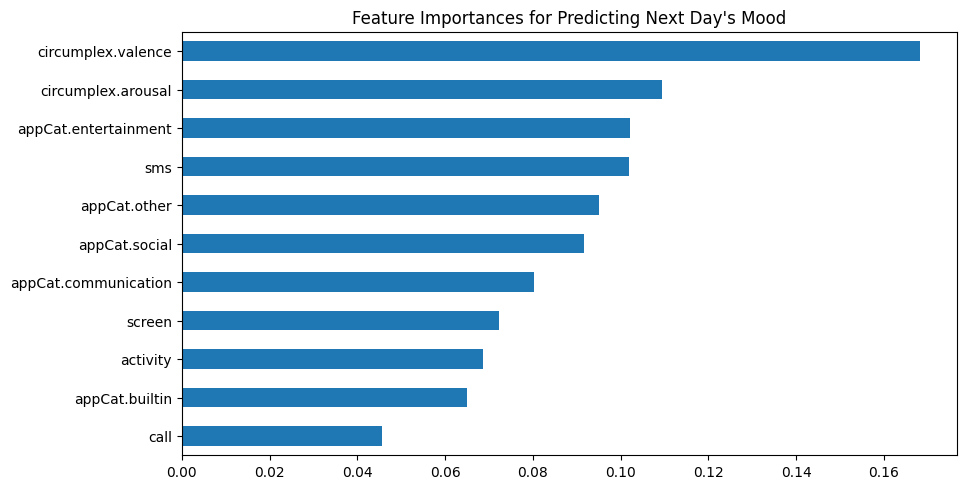

In [11]:
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)

# Sort the feature importances in ascending order for better visualization
sorted_importances = feature_importances.sort_values()

# Plot all feature importances
sorted_importances.plot(kind='barh', figsize=(10, len(sorted_importances)/2))  # Adjust the figure height dynamically based on the number of features

plt.title('Feature Importances for Predicting Next Day\'s Mood')
plt.show()


## lasso

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load data
# Assuming df is already loaded as shown

# Convert 'time' to datetime if it's stored as an index or column
df.reset_index(inplace=True)  # If 'id' and 'time' are in the index
df['time'] = pd.to_datetime(df['time'])

# Sort the DataFrame to ensure correct date handling
df.sort_values(by=['id', 'time'], inplace=True)

# Create target by shifting mood by -1, so each day's features predict the next day's mood
df['mood_next_day'] = df.groupby('id')['mood'].shift(-1)

# Create a feature for the previous day's mood
df['mood_previous_day'] = df.groupby('id')['mood'].shift(1)

# Drop rows with any missing target value
df.dropna(subset=['mood_next_day'], inplace=True)

# Optionally handle other NaNs, here filling with zero for simplicity
df.fillna(0, inplace=True)

# Define features and target
X = df.drop(['mood_next_day', 'id', 'time', 'mood'], axis=1)  # Drop non-feature columns and the target
y = df['mood_next_day']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [17]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


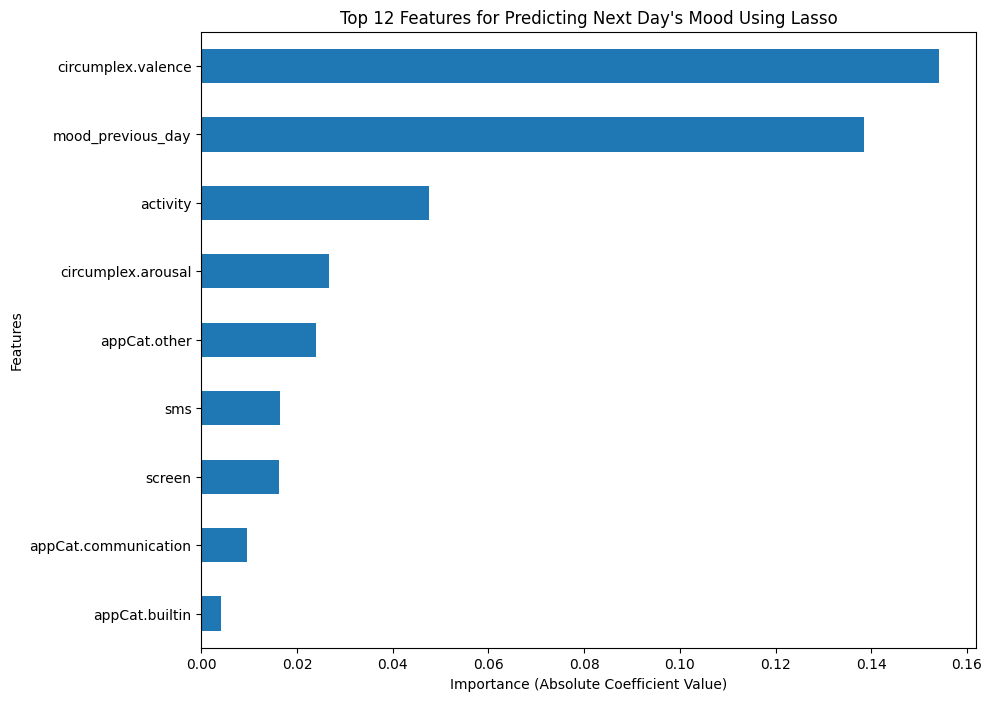

In [19]:
# Fit Lasso model
lasso = Lasso(alpha=0.01)  # You might need to adjust the alpha value based on regularization strength needed
lasso.fit(X_train_scaled, y_train)

feature_importance = pd.Series(lasso.coef_, index=X_train.columns)
top_features = feature_importance.abs().sort_values(ascending=True)  # Sort in ascending for horizontal plot

# Select the top 12 features, ensuring we are looking at non-zero coefficients (if they exist)
top_12_features = top_features[top_features != 0][-12:]

# Plot top features horizontally
top_12_features.plot(kind='barh', figsize=(10, 8))  # Adjust figure size as needed
plt.title('Top 12 Features for Predicting Next Day\'s Mood Using Lasso')
plt.xlabel('Importance (Absolute Coefficient Value)')
plt.ylabel('Features')
plt.show()
